<a href="https://colab.research.google.com/github/guiattard/earthengine-community/blob/master/tutorials/Introduction-GEE-Python-API-guiattard/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to the Google Earth Engine Python API: data catalog exploration, static and interactive mapping
Author: guiattard

Within the last decade, a huge amount of geospatial data, such as satellite data (e.g. land surface temperatures, vegetation) or the output of large scale, even global models (e.g. wind speed, groundwater recharge), have become freely available from multiple national agencies and universities (e.g. NASA, USGS, NOAA, and ESA). These geospactial data are used every day by scientists and engineers of all fields, to predict weather, prevent disasters, secure water supply or study the consequences of climate change. When using these geospatial data, things fast becomes tricky and the following questions arise:
– What data is available and where can we find it ?
– How can we access these data?
– How can we manipulate these petabytes of data?

In this article, an introduction to the Google Earth Engine Python API is presented. After some setups and some exploration of the Earth Engine Data Catalog, we’ll see how to handle geospatial datasets with pandas and make some plots with matplotlib. 

First, we’ll see how to get the timeseries of a variable on a region of interest. An application of this procedure will be done to extract Land Surface Temperature in an urban and a rural area near the city of Lyon (France) to illustrate the heat island effect. Secondly, we will focus on static mapping and a procedure to export the result in a geotiff file will be detailed. 

Finally, the folium library will be introduced to make interactive maps. In this last part, we’ll see how to include some GEE datasets as tiles layers of a folium map.

### Exploration of the Earth Engine Data Catalog

Have you ever thought that getting a meteorological dataset could be as easy as finding the nearest pizzeria? To convince you, go [here](https://developers.google.com/earth-engine/datasets/catalog) and play with the search bar and select the dataset you want to explore.

Let's say that we need to know the elevation of a region, some soil properties (e.g. clay/sand/silt content) and some meteorological data (e.g. temperature, precipitation, evapotranspiration). Well, inside the Earth Engine Catalog we find:
- global elevation with a resolution of 30m is available [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003),
- [OpenLandMap datasets](https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_CLAY-WFRACTION_USDA-3A1A1A_M_v02) with some soil porperties with a resolution of 250m (e.g. clay, sand, and silt content) 
- temperature, precipitation and evapotranspiration datasets with different resolution. For example you can explore the [GRIDMET model data](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET) from the University of Idaho or for streight up satelite derived values look into the [MODIS Collections](https://developers.google.com/earth-engine/datasets/catalog/modis), etc.

Of course the resolution, frequency, spatial and temporal extent as well as data source (e.g. satelite image, interpolated station data, or model output) vary from one dataset to another. Therefore, read the description carefully and make sure you know what kind of dataset you are selecting!


### Run me first

First of all, run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Wwg8AnDEnllaznoIM3bf6AQvDf6ynCIc6chKCbk7jYY&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6SJhg2m89arjZjbyCGWlzSe-ZgyToHYzw6jVDWMETypkJV_GIgpOc

Successfully saved authorization token.


### Start to play with collections

In the Earth Engine Catalog, datasets can have different shapes. Basically, we work with:
- *features* which are geometric objects with a list of properties. For example, a watershed with some properties such as *name*, *area*, is a feature. 
- *image* which are like features, but may include several bands. For example, The ground elevation given by the USGS [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) is an image.
- *collections* which are group of features or images. For example, the [Global Administrative Unit Layers](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0) giving administrative boundaries is a *featureCollection* and the [MODIS Land Surface Temperature](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) dataset is an imageCollection.

If you want to know more about different data models, you may want to visit the [earth engine user guide](https://developers.google.com/earth-engine) 

In the following, we work with the MODIS [Land Cover (LC)](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1), the MODIS [Land Surface Temperature (LST)](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) and with the USGS [Ground Elevation (ELV)](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) which are *imageCollections*. The descriptions provide us with all the information we need to import and manipulate these datasets: the availability, the provider, the Earth Engine Snippet, and the available bands associated to the collection. 

Now, to import the LC, LST and ELV collections, we can copy and paste the Earth Engine Snippets:


In [25]:
# import a land cover Collection
LC = ee.ImageCollection('MODIS/006/MCD12Q1')

# import a land surface temperature Collection
LST = ee.ImageCollection('MODIS/006/MOD11A1')

# import a ground elevation Image
ELV = ee.Image('USGS/SRTMGL1_003')

All of these images come in a different resolution, frequency, and possibly projection, ranging from daily images in a 1 km resolution for LST (hence an ee.ImageCollection - a collection of several ee.Images) to a sinlge image giving data for the year 2000 in a 30 m resolution for the ELV. While we need to have an eye on the frequency, GEE takes care of resolution and projection by resampling and reprojecting all data we are going to work with to a common projection. We can define the resolution (called scale in GEE) whenever necessary and of course have the option to force no reprojection.

As you can see in the description of the datasets, they include several sets of information stored in several bands. For example, these bands are associated to the LST collection:
- LST_Day_1km: Daytime Land Surface Temperature
- Day_view_time: Local time of day observation,
- LST_Night_1km: Nighttime Land Surface Temperature,
- ...

The description page of the collection tells us that the name of the band associted to the daytime LST is 'LST_Day_1km' which is in Kelvin. In addition, values are ranging from 7500 to 65535 with a corrective scale of 0.02. 

Then, we have to select the bands we want to work with. Therefore, we decide to focus on daytime LST so we select the daytime band with the .select() command. We also need to filter the collection on the period of time we want. We can do that using the *filterDate()* method.

In [26]:
# initial date of interest - inclusive
i_date = '2017-01-01'

# final date of interest - exclusive
f_date = '2020-01-01' 

# selection of appropriate bands and dates for LST
LST = LST.select('LST_Day_1km').filterDate(i_date, f_date)

Now, we can either upload existing shape files or define some points with longitude and latitude coordinates where we want know more about Land cover, Land Surface Temperature and Elevation. For example, let's take two:
- The first one in the urban area of Lyon (France)
- The second one, 30 kilometers away the city center, in a rural area

In [27]:
# Definition of the urban location of interest with a point
u_lon = 4.8148 #longitude of the location of interest
u_lat = 45.7758 #latitude of the location of interest
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Definition of the rural location of interest with a point
r_lon = 5.175964 #longitude of the location of interest
r_lat = 45.574064 #latitude of the location of interest
r_poi = ee.Geometry.Point(r_lon, r_lat)

We can easily get information about our region/point of interest using following methods (to get more information about available methods and required arguments, please visit the API documentation [here](https://developers.google.com/earth-engine/api_docs)):
- *sample()*: samples the image (does NOT work for an image collection - we'll talk about sampeling an image collection later) according to a given geometry and a scale (in meters) of the projection to sample in. It restuns a featureCollection.
- *first()*: returns the first entry of the collection,
- *get()*: to select the appropriate band of your Image/Collection,
- *getInfo()*: returns the value, not just the object.

Then we can evaluation the ground elevation and LST around our point of interest using the following commands. Please be careful when evaluating LST. According to the [dataset description](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1), the value should be corrected by a factor of 0.02 to get Kelvins (do not forget the conversion). To get the mean mulit-annual daytime LST, we use the *mean()* method on the LST ImageCollection. (The following run might take some time: about 15-20 seconds for me)

In [28]:
scale = 1000 #scale in meters

# Print the elevation near Lyon (France)
elv = ELV.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation around the point:', elv, 'm')

# Print the daytime LST near Lyon (France)
# To take the mean value of the LST on the collection, we use the .mean() method:
lst = LST.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST around the point:', round(lst*0.02 -273.15,2), '°C')

# Print the land cover type around the point:
lct = LC.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('The land cover value around the point is:', lct)

Ground elevation around the point: 196 m
Average daytime LST around the point: 23.12 °C
The land cover value around the point is: 13


Going back to the band description of the LC dataset, we see that a LC value of "13" corresponds to an urban land. You can run the above cells with the rural point coordinates if you want to notice a difference.

### Get some time series

Now that you see we can get geospatial information about a place of interest pretty easily, you may want to get some timeseries, probably make some charts and draw get statistics about a place. Hence, we import the data at the given locations using the *getRegion()* method.

In [29]:
#here is the buffer zone we consider around each point : 1000m
buffer_points = 1000 

# We get the data for the point in urban area
LST_u_poi = LST.getRegion(u_poi, buffer_points).getInfo()
# We get the data for the point in rural area
LST_r_poi = LST.getRegion(r_poi, buffer_points).getInfo() 

LST_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km'],
 ['2017_01_01', 4.810478346460038, 45.77365530231022, 1483228800000, None],
 ['2017_01_02', 4.810478346460038, 45.77365530231022, 1483315200000, None],
 ['2017_01_03', 4.810478346460038, 45.77365530231022, 1483401600000, None],
 ['2017_01_04', 4.810478346460038, 45.77365530231022, 1483488000000, 13808]]

Printing the first 5 lines of the result shows that we now have arrays full of data. We now define a function to transform this array into a pandas Dataframe which is much more convenient to manipulate.

In [30]:
import pandas as pd

def ee_array_to_df(arr, band):
    """
    We create a function with an array as input
    We return a pandas df
    """
    df = pd.DataFrame(arr)
    
    # we rearrange the header
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns = headers)

    # we remove raws without data inside:
    df = df[['longitude', 'latitude', 'time', band]].dropna()
    
    # We converr the data to numeric values
    df[band] = pd.to_numeric(df[band], errors='coerce')
    
    # We also convert the Time filed into a datetime
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')
    
    # We keep the columns we want
    df = df[['time','datetime', band]]
    
    return df

We apply this function to get the two timeseries we want (and we print one):

In [31]:
LSTdf_urban = ee_array_to_df(LST_u_poi,'LST_Day_1km')

#Do not forget that the LST is corrected with a scale of 0.02.
#So we convert the appropriate field of the dataframe to get temperature in celcius:
LSTdf_urban['LST_Day_1km'] = 0.02*LSTdf_urban['LST_Day_1km'] - 273.15

#We do the same for the rural point:
LSTdf_rural = ee_array_to_df(LST_r_poi,'LST_Day_1km')
LSTdf_rural['LST_Day_1km'] = 0.02*LSTdf_rural['LST_Day_1km'] - 273.15 

LSTdf_urban.head()

,time,datetime,LST_Day_1km
3,1483488000000,2017-01-04,3.01
4,1483574400000,2017-01-05,2.39
5,1483660800000,2017-01-06,0.89
6,1483747200000,2017-01-07,-0.11
15,1484524800000,2017-01-16,2.33


Now that we have our data in a good shape, we can easily make plots and compare the trends. As Land Surface Temperature has a seasonality influence, we expect that data looking something like $LST(t) = LST_{0} (1 + sin(\omega t + \phi))$

Consequently, on the top of the data scatter plot, we plot the fitting curve using the scipy library:

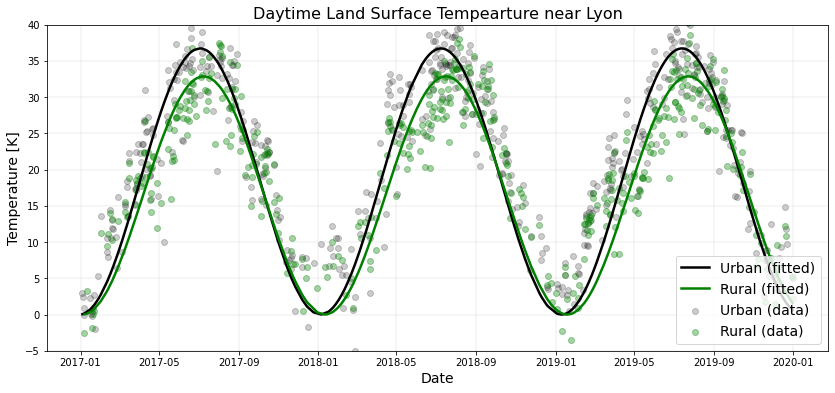

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting Curves:
## first, we extract x values (times) from our dfs
x_data_u = np.asanyarray(LSTdf_urban['time'].apply(float)) #urban
x_data_r = np.asanyarray(LSTdf_rural['time'].apply(float)) #rural

## Secondly, we extract y values (LST) from our dfs
y_data_u = np.asanyarray(LSTdf_urban['LST_Day_1km'].apply(float)) #urban
y_data_r = np.asanyarray(LSTdf_rural['LST_Day_1km'].apply(float)) #rural

## Then, we define the fitting function with parameters a, b, c, d:
def fit_func(x, a, b, c):
    return a*(np.sin(b*x + c) + 1)

## We optimize the parameters using a good start p0
params_u, params_covariance_u = optimize.curve_fit(fit_func, x_data_u, y_data_u, p0 = [20., 0.002*np.pi/(365.*24.*3600.), 350])
params_r, params_covariance_r = optimize.curve_fit(fit_func, x_data_r, y_data_r, p0 = [20., 0.002*np.pi/(365.*24.*3600.), 350])

# Subplots
fig, ax = plt.subplots(figsize=(14, 6))

# We add scatter plots
ax.scatter(LSTdf_urban['datetime'], LSTdf_urban['LST_Day_1km'], 
           c = 'black', alpha = 0.2, label = 'Urban (data)')
ax.scatter(LSTdf_rural['datetime'], LSTdf_rural['LST_Day_1km'], 
           c = 'green', alpha = 0.35, label = 'Rural (data)')

# We add fitting curves
ax.plot(LSTdf_urban['datetime'], fit_func(x_data_u, params_u[0], params_u[1], params_u[2]), 
        label='Urban (fitted)', color = 'black', lw = 2.5)
ax.plot(LSTdf_rural['datetime'], fit_func(x_data_r, params_r[0], params_r[1], params_r[2]), 
        label='Rural (fitted)', color = 'green', lw = 2.5)

# We add some parameters
ax.set_title('Daytime Land Surface Tempearture near Lyon', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Temperature [K]', fontsize = 14)
ax.set_ylim(-5, 40)
ax.grid(lw = 0.2)
ax.legend(fontsize = 14, loc = 'lower right')

plt.show()

### Static mapping of Land Surface Temperature and Ground Elevation

#### Get a static map

Now, we want to get static maps of Land surface Temperature and Ground Elevation around a region of interest. We define this region of interest using a buffer zone of 1000 km around Lyon (France).

In [33]:
# Definition of a region of interest with a buffer zone around Lyon

roi = u_poi.buffer(1000000)

Also, we have to convert the LST ImageCollection into an Image, for example by taking the mean value of each pixel over the period of interest. And we convert the value of pixels into Celsius:

In [34]:
# ImageCollection to Image using the mean() method:
LST_im = LST.mean()

# Operation to take into account the scale factor:
LST_im = LST_im.select('LST_Day_1km').multiply(0.02)

# Kelvin -> Celsius
LST_im = LST_im.select('LST_Day_1km').add(-273.15)

Then, we use the *getThumbUrl()* method to get an url and we can use the IPython librairy to plot the mean daytime LST map on the region of interest. Blue represents the coldest areas (< 10°C) and red represents the warmest areas (>30°C). (For me, the following run is quite long and the image can pop some times after the task appears to be finished)

In [35]:
from IPython.display import Image

# Create the url associated to the Image you want
url = LST_im.getThumbUrl({'min': 10, 'max': 30, 'dimensions': 512,
                          'region' : roi,
                          'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display a thumbnail Land Surface Temperature in France
Image(url = url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2101eb2c9d6e511d40b363c5931b9091-bf8c09e737134e99ba1a3c4da949607a:getPixels


We do the same for ground elevation:

In [45]:
#To hide elevation below sea level
ELV = ELV.updateMask(ELV.gt(0)) 

# Then we get the image
Image(url = ELV.updateMask(ELV.gt(0))
  .getThumbURL({'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

Of course you may want to have a closer look around a specific part of the map. So let's define an other region, adjust the min/max scale and display:

In [46]:
# We create a buffer zone of 10km around our point of interest
lyon = u_poi.buffer(10000)

url3 = ELV.getThumbUrl({'min': 150, 'max': 350, 'region' : lyon,
                        'dimensions': 512,
                        'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url = url3)

#### Clip an image on a region of interest

In case you want to display an image over a given reagion (and nbot outside), we can clip our dataset using the region as an argument of the *clip()* method. Let's say that we want to display the ground elevation in France. We can get the geometry of the administrative boundary of France with the [FAO featureCollection](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0) and do as same as before:

In [47]:
# We get the feature collection of Administrative boundaries (level0)
countries = ee.FeatureCollection("FAO/GAUL/2015/level0").select('ADM0_NAME')

# We filter the featureCollection to get the feature we want
france = countries.filter(ee.Filter.eq('ADM0_NAME', 'France'))

# We clip the image on France
ELV_fr = ELV.clip(france)

# Create the url associated to the Image you want
url4 = ELV_fr.getThumbUrl({'min': 0, 'max': 2500, 'region' : roi,
                                              'dimensions': 512,
                                              'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
# Display a thumbnail of elevation in France.
Image(url = url4)

### Export a geotiff file

After manipulating Earth Engine datasets, you may need to export a resulting Image to a geotiff. For example, to use it as an input of a numerical model, or to overlap it with personnal georeferecend files in your favorite GIS. There are multiple ways to do that. Here we explore two:
- In the first option, we save the Image you want in the Google Drive,
- In the second option, we directly download the Image.

#### Save a GeoTIFF file in your Google Drive

To export the image to our Google Drive, we have to define a task and start it. We have to specify the size of pixels (here 30 m), the projection (here EPSG:4326), the file format (here GeoTIFF) and the region of interest (here the area of lyon defined before).

In [39]:
task = ee.batch.Export.image.toDrive(image = ELV, description = 'Elevation_near_Lyon_France',
                                     scale = 30, region = lyon.getInfo()['coordinates'],
                                     fileNamePrefix = 'my_export_Lyon', crs = 'EPSG:4326',
                                     fileFormat = 'GeoTIFF')
task.start()

Then we can check the status of our task:

In [40]:
task.status()

{'creation_timestamp_ms': 1605859275365,
 'description': 'Elevation_near_Lyon_France',
 'id': 'HXMFY3YF47PXCUIWOOT7SYKZ',
 'name': 'projects/earthengine-legacy/operations/HXMFY3YF47PXCUIWOOT7SYKZ',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1605859275365}

Now you can check your google drive to find your file.

#### Get a link to download your GeoTIFF

Similarly, we can use the getDownloadUrl() method and click on the provided link.


In [41]:
link = LST_im.getDownloadUrl({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat' : 'GeoTIFF',
    'region': lyon.getInfo()['coordinates']})
print(link)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5540f35135a0889991f7aa8b02edfc2-864481770f70e69ccbddea4ab6718096:getPixels


### Interactive mapping using folium

To display these GEE datasets on an interactive map, let me introduce you to folium. Folium is a python library based on leaflet.js ([Open-source JavaScript library for mobile-friendly interactive maps](https://leafletjs.com/)) that you can use to make interactive maps. Folium supports WMS, GeoJSON layers, vector layers and tile layers which make it very convenient and straightforward to visulatise the data we manipulate with python. We create our first interactive map with one line of code, specifying the location where we want to center the map, the zoom strat, and the main dimensions of the map :

In [42]:
import folium

my_map = folium.Map(location=[45.77, 4.855], zoom_start=10, width=500, height=500)
my_map

On top of this map, we now want to add the GEE layers we studied before: Land Cover (LC), Land Surface Temperature (LST) and Ground Elevation Model (GEM). For each GEE dataset, the process consists in adding a new tile layer to our map specifying some visualisation parameters. Let's define a new method for handing Earth Engine tiles and using it to display an elevation model to a Leaflet map.

In [43]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

We want to respect the common LC classes defined in the table of the previous section (hexadecimal codes are given for each class: water bodies are blue, urban area are grey, forests are green, etc.). Then we define visualisations parameters associated to LC and apply the method we defined earlier:

In [44]:
#selection of appropriate bands and dates for LC
LC_im = LC.select('LC_Type1').filterDate(i_date).first() 

# Set visualization parameters for land cover.
LCvis_params = {'min': 1,'max': 17,
                'palette': ['05450a','086a10', '54a708', '78d203', '009900',
                            'c6b044', 'dcd159', 'dade48', 'fbff13', 'b6ff05',
                            '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c', '69fff8',
                            'f9ffa4', '1c0dff']}
# We create a map
my_map = folium.Map(location=[45.77, 4.855], zoom_start=7, width=500)

# Add the Land Cover to the map object.
my_map.add_ee_layer(LC_im, LCvis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Finally, the map can be saved in *html* using the command below. Then, you can open it with your favorite navigator.


In [23]:
my_map.save("my_LC_interactive_map.html")

Of course we can add other datasets similarly, by defining some visualization parameters and by addind the approriate tiles:

In [48]:
# Set visualization parameters for the ground elevation
ELVvis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface Temperature.
LSTvis_params = {
  'min': 0,
  'max': 40,
  'palette': ['white','blue','green','yellow','orange','red']}

# We arrange our tiles inside a list (Elevation, LST and Land Cover):
ee_tiles = [ELV_im, LST_im, LC_im]

# We arrange our visualisation parameters inside a list:
ee_vis_params = [ELVvis_params, LSTvis_params, LCvis_params]

# We arrange our tiles names inside a list:
ee_tiles_names = ["Elevation", "Land Surface Temperature", "Land Cover"]

# We create a new map
my_map = folium.Map(location=[45.77, 4.855], zoom_start=5, width=500, height=500)

# We make a loop over our layers
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
  my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

### Documentation

- The full documentation of the Google Earth Engine Pyhton API is available [here](https://developers.google.com/earth-engine/api_docs)
- The Google Earth engine User Guide is available [here](https://developers.google.com/earth-engine)
- Some tutorials are available [here](https://developers.google.com/earth-engine/tutorials)
- An example based on the Google Earth Engine Javascript console dedicated to Land Surface Temperature estimation is provided in the open access supplementary material of [Benz et al., (2017)](https://iopscience.iop.org/article/10.1088/1748-9326/aa5fb0/meta). You can access the code [here](https://code.earthengine.google.com/4a1bc64dbc3351a1e364490758d4cf2d).

### Acknoledgements

Thank's to Susanne Benz for reviewing and helping in writting this tutorial.